<a href="https://colab.research.google.com/github/santhiravuri/generative-ai-internship/blob/main/day3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Hands on : Build and Train a VAE

import torch
from torch import nn,optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
import torch
import torch.nn as nn

# Encoder definition
class Encoder(nn.Module):  # Fixed typo: 'Modue' → 'Module'
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)        # Fixed missing '='
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)    # Fixed typo: 'linear' → 'Linear'

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Decoder definition
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))


In [ ]:
#define VAE  with sampling
class VAE(nn.Module):
       def __init__(self, input_dim, hidden_dim, latent_dim):
           super().__init__()
           self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
           self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

       def reparameterize(self, mu, logvar):
           std = torch.exp(0.5 * logvar)
           eps = torch.randn_like(std)
           return mu + eps * std

       def forward(self, x):
           mu, logvar = self.encoder(x)
           z = self.reparameterize(mu, logvar)
           return self.decoder(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
       BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
       KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
       return BCE + KLD


In [ ]:
# 5. Train the VAE

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.85MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


Epoch 1, Loss: 163.3902
Epoch 2, Loss: 120.7459
Epoch 3, Loss: 114.2990
Epoch 4, Loss: 111.4222
Epoch 5, Loss: 109.7523
Epoch 6, Loss: 108.5739
Epoch 7, Loss: 107.6914
Epoch 8, Loss: 107.0568
Epoch 9, Loss: 106.5237
Epoch 10, Loss: 106.1405


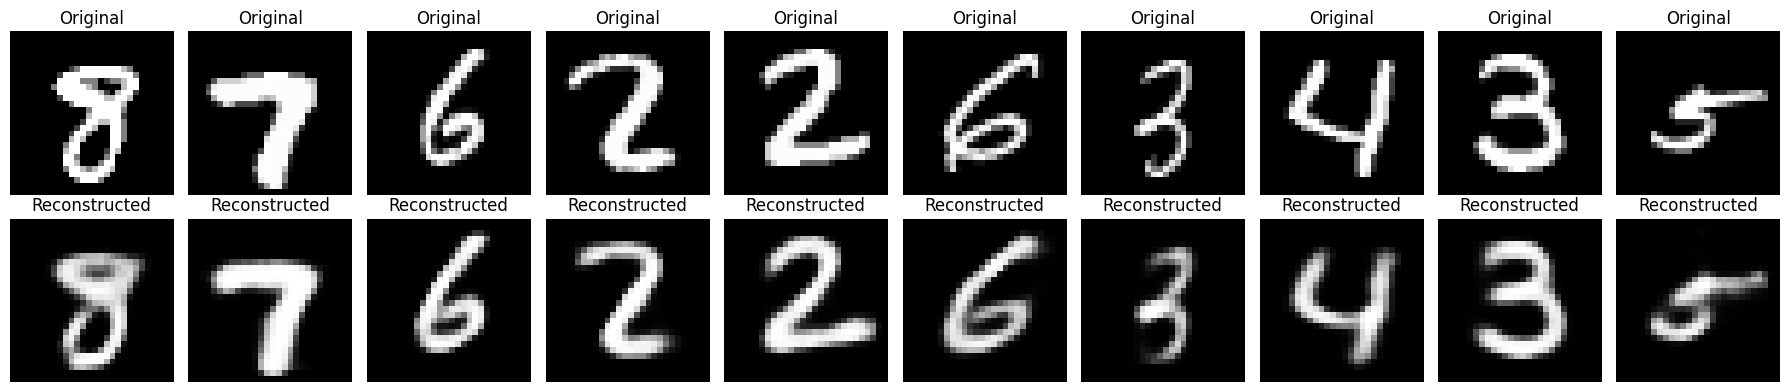

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Get a batch of test images
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# Take one batch
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 784).to(device)
        recon_batch, _, _ = model(data)
        break  # Just one batch is enough for visualization

# Convert tensors to numpy arrays
originals = data.view(-1, 28, 28).cpu().numpy()
reconstructions = recon_batch.view(-1, 28, 28).cpu().numpy()

# Plot
n = 10  # Number of images to display
plt.figure(figsize=(18, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(originals[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i], cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()